<a href="https://colab.research.google.com/github/Koks-creator/ner-app/blob/main/ner_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Get Data

In [ ]:
import kagglehub

path = kagglehub.dataset_download("namanj27/ner-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ner-dataset


In [ ]:
!tail /root/.cache/kagglehub/datasets/namanj27/ner-dataset/versions/2/ner_datasetreference.csv

,impact,NN,O
,.,.,O
Sentence: 47959,Indian,JJ,B-gpe
,forces,NNS,O
,said,VBD,O
,they,PRP,O
,responded,VBD,O
,to,TO,O
,the,DT,O
,attack,NN,O


In [ ]:
ORIGINAL_DATA_PATH = "/root/.cache/kagglehub/datasets/namanj27/ner-dataset/versions/2/ner_datasetreference.csv"

In [ ]:
from pathlib import Path
from datetime import datetime
from typing import List, Tuple
import chardet
from collections import Counter
import pickle
import re
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

#2. Fix data because encoding is fucked

In [ ]:
def fix_data_file(data_path: Path) -> pd.DataFrame:
    with open(data_path, 'rb') as f:
        raw_data = f.read(10000)  # read first 10KB
        result = chardet.detect(raw_data)
        print(f"Detected encoding: {result}")

    detected_encoding = result['encoding']

    # some encoding and shit
    encodings_to_try = [
        'unicode_escape',
        detected_encoding,
        'latin-1',
        'cp1252',
        'iso-8859-1',
        'utf-8-sig',
        'ascii'
    ]

    for encoding in encodings_to_try:
        if encoding is None:
            continue
        try:
            print(f"Trying {encoding=}")
            df = pd.read_csv(data_path, encoding=encoding)

            print(f"{encoding=} works")
            df.to_csv('ner_dataset_fixed.csv', index=False, encoding='utf-8')
            print("Saved to 'ner_dataset_fixed.csv'8")

            return df
        except Exception as e:
            print(f"{encoding=} failed: {e}")


fix_data_file(ORIGINAL_DATA_PATH)

Detected encoding: {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
Trying encoding='unicode_escape'
encoding='unicode_escape' works
Saved to 'ner_dataset_fixed.csv'8


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


#3. Analyze data for a bit

In [ ]:
DATA_PATH = "/content/ner_dataset_fixed.csv"

In [ ]:
data = pd.read_csv(DATA_PATH)

In [ ]:
data.groupby("Tag").count()

,Sentence #,Word,POS
Tag,,,
B-art,18,402,402
B-eve,10,308,308
B-geo,3335,37644,37644
B-gpe,2989,15870,15870
B-nat,11,201,201
B-org,2752,20143,20143
B-per,4019,16990,16990
B-tim,515,20333,20333
I-art,0,297,297


In [ ]:
missing = data.isnull().sum()
print(missing)

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64


#4. Preparing data

forward fill for sentences in order to fill empty sentence ids from: <br> sent #0 none none sent #1 none none
<br>to<br> sent #0 sent #0 sent #0 sent #1 sent #1 sent #1

In [ ]:
data["Sentence #"] = data["Sentence #"].ffill()

In [ ]:
missing = data.isnull().sum()
print(missing)

Sentence #     0
Word          10
POS            0
Tag            0
dtype: int64


In [ ]:
data[data["Word"].isnull()]

,Sentence #,Word,POS,Tag
197658,Sentence: 9047,NaN,NN,O
256026,Sentence: 11709,NaN,NN,O
257069,Sentence: 11759,NaN,NN,O
571211,Sentence: 26129,NaN,NN,O
613777,Sentence: 28049,NaN,NN,O
747019,Sentence: 34152,NaN,NN,O
901758,Sentence: 41181,NaN,NN,O
903054,Sentence: 41244,NaN,NN,O
944880,Sentence: 43177,NaN,NN,O
1003438,Sentence: 45887,NaN,NN,O


In [ ]:
data.query("Tag == 'B-tim'").head(50)

,Sentence #,Word,POS,Tag
167,Sentence: 8,Wednesday,NNP,B-tim
211,Sentence: 10,Wednesday,NNP,B-tim
274,Sentence: 13,Tuesday,NNP,B-tim
341,Sentence: 15,Wednesday,NNP,B-tim
493,Sentence: 21,Wednesday,NNP,B-tim
654,Sentence: 28,Sunday,NNP,B-tim
679,Sentence: 29,Saturday,NNP,B-tim
684,Sentence: 30,Friday,NNP,B-tim
740,Sentence: 33,Saturday,NNP,B-tim
848,Sentence: 36,Thursday,NNP,B-tim


In [ ]:
grouped_sent = data.groupby("Sentence #")

creating full sentences - from tokenized to list of words

In [ ]:
sentences_data = []
sentence_lengths = []
sents_length = {
    "0-30": 0,
    "30-50": 0,
    "50-60": 0,
    "60-70": 0,
    "70-110": 0
}

nan_words_tags = 0
for sent_id, group in grouped_sent:
    words = group["Word"].tolist()
    tags = group["Tag"].tolist()

    clean_words = []
    clean_tags = []
    for word, tag in zip(words, tags):
        if pd.notna(word) and pd.notna(tag):
            clean_words.append(str(word).strip())
            clean_tags.append(str(tag).strip())
        else:
            nan_words_tags += 1

    for key in sents_length:
        left_if, right_if = [int(k) for k in key.split("-")]
        if left_if < len(clean_words) < right_if:
            sents_length[key] += 1

    if clean_words and clean_tags:
        sentences_data.append({
            'sentence_id': sent_id,
            'words': clean_words,
            'tags': clean_tags,
            'length': len(clean_words)
        })
        sentence_lengths.append(len(clean_words))

print(f"{len(sentences_data)=}")
print(f"{min(sentence_lengths)=}")
print(f"{max(sentence_lengths)=}")
print(f"{np.mean(sentence_lengths)=}")
print(f"{np.median(sentence_lengths)=}")
print(f"{nan_words_tags=}")
print(f"{sents_length=}")

len(sentences_data)=47959
min(sentence_lengths)=1
max(sentence_lengths)=104
np.mean(sentence_lengths)=np.float64(21.863779478304384)
np.median(sentence_lengths)=np.float64(21.0)
nan_words_tags=10
sents_length={'0-30': 40167, '30-50': 6418, '50-60': 72, '60-70': 13, '70-110': 4}


In [ ]:
sentences_data[0]

{'sentence_id': 'Sentence: 1',
 'words': ['Thousands',
  'of',
  'demonstrators',
  'have',
  'marched',
  'through',
  'London',
  'to',
  'protest',
  'the',
  'war',
  'in',
  'Iraq',
  'and',
  'demand',
  'the',
  'withdrawal',
  'of',
  'British',
  'troops',
  'from',
  'that',
  'country',
  '.'],
 'tags': ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-gpe',
  'O',
  'O',
  'O',
  'O',
  'O'],
 'length': 24}

creating mappings

In [ ]:
word_counts = Counter()
tag_counts = Counter()

for sent in sentences_data:
    if len(sent["words"]) != len(sent["tags"]):
        print(f"Skipping - length diff: {len(sent['words'])=} vs {len(sent['tags'])=}")
        continue

    words_lower = [word.lower() for word in sent["words"]]
    word_counts.update(words_lower)
    tag_counts.update(sent['tags'])

word2idx = {"<PAD>": 0, '<UNK>': 1}
for word, count in word_counts.items():
    if word not in word2idx:
        word2idx[word] = len(word2idx)

tag2idx = {"<PAD>": 0}
for tag, count in tag_counts.items():
    if tag not in tag2idx:
        tag2idx[tag] = len(tag2idx)

idx2word = {idx: word for word, idx in word2idx.items()}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

In [ ]:
len(word2idx)

31819

In [ ]:
tag_counts

Counter({'O': 887898,
         'B-geo': 37644,
         'B-gpe': 15870,
         'B-tim': 20333,
         'B-org': 20143,
         'I-geo': 7414,
         'B-per': 16990,
         'I-per': 17251,
         'I-org': 16784,
         'I-tim': 6528,
         'B-art': 402,
         'I-art': 297,
         'B-nat': 201,
         'I-gpe': 198,
         'I-nat': 51,
         'B-eve': 308,
         'I-eve': 253})

Tags:

- B - Begin entity
- I - Inside entity continuation
- geo - geographic locations (mountains, rivers)
- gpe (geopolitical entity) - countries, cities, states
- tim (time) - time expressions (dates, periods)
- org (organization) - organizations, companies, institutions
- per (person) - person names
- art (artifact) - books, movies, artworks
- nat (nationality) - nationalities, ethnic groups
- eve (event) - events (wars, festivals, competitions)

Example: "John Smith lives in London" → B-per I-per O O B-gpe

In [ ]:
MAX_LEN = 70
VAL_TEST_SIZE = .2
TEST_SIZE = .5

encoding data

In [ ]:
X = []
y = []

for sent in sentences_data:
    words = sent["words"]
    tags = sent["tags"]

    if len(sent["words"]) != len(sent["tags"]):
        print(f"Skipping - length diff: {len(sent['words'])=} vs {len(sent['tags'])=}")
        continue

    word_indices = []
    for word in words:
        word_lower = word.lower()
        word_idx = word2idx.get(word_lower, word2idx["<UNK>"])
        word_indices.append(word_idx)

    tag_indices = []
    for tag in tags:
        idx = tag2idx.get(tag, tag2idx.get("<PAD>", 0))
        tag_indices.append(idx)

    if len(word_indices) > MAX_LEN:
        word_indices = word_indices[:MAX_LEN]
        tag_indices = tag_indices[:MAX_LEN]
    else:
        pad_len = MAX_LEN - len(word_indices)
        word_indices.extend([0] * pad_len)
        tag_indices.extend([0] * pad_len)

    X.append(word_indices)
    y.append(tag_indices)

X = np.array(X)
y = np.array(y)

print(f"{X.shape=}")
print(f"{y.shape=}")
print(f"{len(X)=}")

X.shape=(47959, 70)
y.shape=(47959, 70)
len(X)=47959


creating train, val and test datasets

In [ ]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, test_size=VAL_TEST_SIZE, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=TEST_SIZE, random_state=42
)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(38367, 70)
(4796, 70)
(4796, 70)


In [ ]:
len(word2idx)//100

318

#5. Building model and training

In [ ]:
EPOCHS = 3
BATCH_SIZE = 32
EMBEDDING_DIM = 256
LSTM_UNITS = 128
vocab_size = len(word2idx)
tagset_size = len(tag2idx)

model arch

In [ ]:
def build_model(vocab_size: int, tagset_size: int, embedding_dim: int, lstm_units: int) -> keras.Model:
    model = tf.keras.Sequential([
        # embedding - converts words indexes to vectors
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
        ),

        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                lstm_units,
                return_sequences=True,
                dropout=0.3,
                recurrent_dropout=0.3
            )
        ),

        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                lstm_units // 2,
                return_sequences=True,
                dropout=0.3,
                recurrent_dropout=0.3
            )
        ),

        tf.keras.layers.Dropout(0.5),

        # TimeDistributed - dense with softmax for each word
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(tagset_size, activation="softmax")
        )
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [ ]:
model = build_model(
    vocab_size=vocab_size,
    tagset_size=tagset_size,
    embedding_dim=EMBEDDING_DIM,
    lstm_units=LSTM_UNITS
  )

train

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    verbose=1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/3
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 1017s 830ms/step - accuracy: 0.9460 - loss: 0.2360 - val_accuracy: 0.9858 - val_loss: 0.0498
Epoch 2/3
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 1080s 866ms/step - accuracy: 0.9869 - loss: 0.0473 - val_accuracy: 0.9879 - val_loss: 0.0411
Epoch 3/3
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 1004s 834ms/step - accuracy: 0.9898 - loss: 0.0351 - val_accuracy: 0.9882 - val_loss: 0.0397


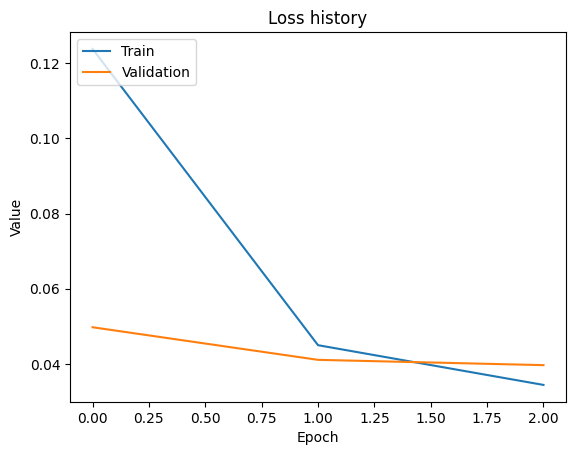

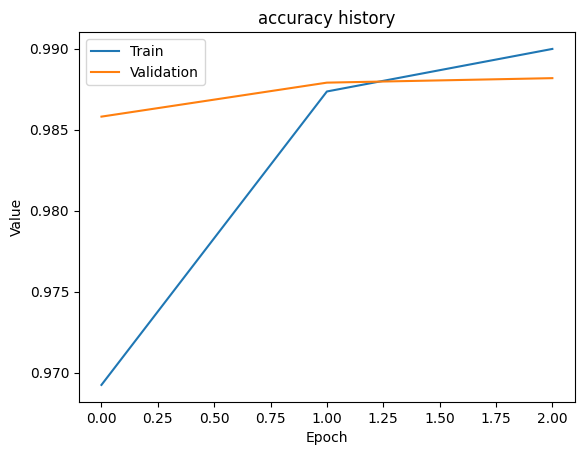

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss history")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("accuracy history")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#6. Validating test data

In [ ]:
def tokenize_sentence(sentence):
    tokens = word_tokenize(sentence.lower().replace("'", ""))
    return tokens

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def get_prediction(text: str) -> List[Tuple[str, str]]:
    tokens = tokenize_sentence(text)
    word_indices = []

    # words to indexes
    for word in tokens:
        word_indices.append(
            word2idx.get(word, word2idx['<UNK>'])
        )

    # padding
    if len(word_indices) > MAX_LEN:
        word_indices = word_indices[:MAX_LEN]
        tokens = tokens[:MAX_LEN]
    else:
        padding_length = MAX_LEN - len(word_indices)
        word_indices.extend([0] * padding_length)

    input_data = np.array([word_indices])

    pred = model.predict(input_data)

    # decode
    predicted_tags = []
    for i, token in enumerate(tokens):
        # if i < len(tokens):
        tag_idx = np.argmax(pred[0][i])
        tag = idx2tag[tag_idx]
        predicted_tags.append(tag)

    results = []
    for token, tag in zip(tokens, predicted_tags):
        if tag != '<PAD>':
            results.append((token, tag))

    return results

In [ ]:
# text = "Anna Bem has been working in Microsoft for five years"
text = "The FBI has opened an investigation against former FBI and CIA directors. Russian interference in the US election is in the background. Conference will start at 20.07.2025"
prediction = get_prediction(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


In [ ]:
prediction

[('the', 'O'),
 ('fbi', 'B-org'),
 ('has', 'O'),
 ('opened', 'O'),
 ('an', 'O'),
 ('investigation', 'O'),
 ('against', 'O'),
 ('former', 'O'),
 ('fbi', 'B-org'),
 ('and', 'O'),
 ('cia', 'B-org'),
 ('directors', 'O'),
 ('.', 'O'),
 ('russian', 'B-gpe'),
 ('interference', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('us', 'B-geo'),
 ('election', 'O'),
 ('is', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('background', 'O'),
 ('.', 'O'),
 ('conference', 'O'),
 ('will', 'O'),
 ('start', 'O'),
 ('at', 'O'),
 ('20.07.2025', 'O')]

In [ ]:
predicted_tags = [p[1] for p in prediction]

In [ ]:
predicted_tags

['O',
 'B-org',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-org',
 'O',
 'B-org',
 'O',
 'O',
 'B-gpe',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O']

In [ ]:
margin_error = 2

predictions = model.predict(X_test)
predicted_tags_ids = np.argmax(predictions, axis=-1)

true_false_matrix = (predicted_tags_ids ==y_test)
correct_per_sample = np.sum(true_false_matrix, axis=1)

sequence_lengths = np.array([len(label) for label in y_test])
errors_per_sample = sequence_lengths - correct_per_sample

succeeded = np.sum(errors_per_sample <= margin_error)
failed = len(X_test) - succeeded

test_accuracy = (succeeded / len(X_test))  * 100
print(test_accuracy)

150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step
89.40783986655546


#7. Saving model and mappings

In [ ]:
current_time = datetime.now().strftime("%Y_%m_%d")

model.save(f"res_model/ner_model_{current_time}.h5")

with open(f"res_model/word2idx_{current_time}.pkl", "wb") as w2i_f:
    pickle.dump(word2idx, w2i_f)

with open(f"res_model/tag2idx_{current_time}.pkl", "wb") as t2i_f:
    pickle.dump(tag2idx, t2i_f)

with open(f"res_model/idx2word_{current_time}.pkl", "wb") as i2w_f:
    pickle.dump(idx2word, i2w_f)

with open(f"res_model/idx2tag_{current_time}.pkl", "wb") as i2t_f:
    pickle.dump(idx2tag, i2t_f)